# Experiment 1 

- Fine-tuning of the pre-trained TAPE model in a progressively specialized manner while extending the frozen layers
- Performance evaluation using two external datasets, Shomuradova and ImmuneCODE datatsets, which contain SARS-CoV-2 S-protein <sub>269~-277</sub>(YLQPRTFLL) epitope-specific TCR CDR3βs 

## Training process and model architecture


<img src='res/fig1.png' width='70%'>

Training process for the proposed model. The initial model is cloned from pre-trained Tasks Assessing Protein Embeddings (TAPE) model, adding a classification layer at the end. The pre-trained model is fine-tuned in two rounds in a progressively specialized manner while extending the frozen layers between rounds.

<img src='res/fig2.png' width='30%'>

The proposed model architecture. Input amino acid sequences concatenated by epitope and CDR3β sequences are first encoded into tokens using a tokenizer. Each token is then embedded into a 768-dimensional vector in the pre-trained Tasks Assessing Protein Embeddings (TAPE) model which has 12 encoding layers with 12 self-attention heads in each layer. The final classifier, a 2-layer feed forward network, is then used to predict either binder or not from the output of the TAPE model.

## Global configurations

In [1]:
import logging
import logging.config
import os
import sys
import warnings
from enum import auto
import pandas as pd
import numpy as np
from IPython.core.display import display

rootdir = '/home/hym/trunk/TCRBert'
workdir = '%s/notebook' % rootdir
datadir = '%s/data' % rootdir
srcdir = '%s/tcrbert' % rootdir
outdir = '%s/output' % rootdir

os.chdir(workdir)

sys.path.append(rootdir)
sys.path.append(srcdir)

from tcrbert.exp import Experiment
from tcrbert.predlistener import PredResultRecoder


# Display
pd.set_option('display.max.rows', 2000)
pd.set_option('display.max.columns', 2000)

# Logger
warnings.filterwarnings('ignore')
logging.config.fileConfig('../config/logging.conf')
logger = logging.getLogger('tcrbert')
logger.setLevel(logging.INFO)

# Target experiment
exp_key = 'exp1'
experiment = Experiment.from_key(exp_key)

exp_conf = experiment.exp_conf

display(exp_conf)

2021-11-09 01:40:07 [INFO]: Loaded exp_conf: {'title': 'exp1', 'description': 'Fine-tuning of pre-trained TAPE model in a progressively specialized manner', 'paper': 'exp1', 'model_config': '../config/bert-base/', 'train': {'pretrained_model': {'type': 'tape', 'location': '../config/bert-base/'}, 'data_parallel': False, 'rounds': [{'data': 'dash_vdjdb_mcpas', 'test_size': 0.2, 'batch_size': 128, 'n_epochs': 150, 'n_workers': 12, 'metrics': ['accuracy'], 'optimizer': {'type': 'adam', 'lr': 0.0001}, 'train_bert_encoders': [-10, None], 'early_stopper': {'monitor': 'accuracy', 'patience': 15}, 'model_checkpoint': {'chk': '../output/exp1/train.{round}.model_{epoch}.chk', 'monitor': 'accuracy', 'save_best_only': True, 'period': 1}, 'result': '../output/exp1/train.{round}.result.json'}, {'data': 'iedb_sars2_exc_shomuradova', 'test_size': 0.2, 'batch_size': 128, 'n_epochs': 100, 'n_workers': 12, 'metrics': ['accuracy'], 'optimizer': {'type': 'adam', 'lr': 0.0001}, 'train_bert_encoders': [-6, N

{'title': 'exp1',
 'description': 'Fine-tuning of pre-trained TAPE model in a progressively specialized manner',
 'paper': 'exp1',
 'model_config': '../config/bert-base/',
 'train': {'pretrained_model': {'type': 'tape',
   'location': '../config/bert-base/'},
  'data_parallel': False,
  'rounds': [{'data': 'dash_vdjdb_mcpas',
    'test_size': 0.2,
    'batch_size': 128,
    'n_epochs': 150,
    'n_workers': 12,
    'metrics': ['accuracy'],
    'optimizer': {'type': 'adam', 'lr': 0.0001},
    'train_bert_encoders': [-10, None],
    'early_stopper': {'monitor': 'accuracy', 'patience': 15},
    'model_checkpoint': {'chk': '../output/exp1/train.{round}.model_{epoch}.chk',
     'monitor': 'accuracy',
     'save_best_only': True,
     'period': 1},
    'result': '../output/exp1/train.{round}.result.json'},
   {'data': 'iedb_sars2_exc_shomuradova',
    'test_size': 0.2,
    'batch_size': 128,
    'n_epochs': 100,
    'n_workers': 12,
    'metrics': ['accuracy'],
    'optimizer': {'type': 'ada

## Fine-tuning datasets

### General epitope-specific CDR3β dataset for the first fine-tuning round

- Dash et al. + VDJdb + McPAS

In [2]:
from tcrbert.dataset import TCREpitopeSentenceDataset, CN
from tcrbert.commons import StrUtils


def summary_df(df):
    cols = ['Epitope species', 'Epitope gene', 'Epitope', 'MHC', 'Samples', 'Positives']
    rows = []
    for i, (epitope, subtab) in enumerate(df.groupby([CN.epitope])):
        row = subtab.iloc[0]
        especies = StrUtils.default_str(row[CN.epitope_species], '-')
        egene = StrUtils.default_str(row[CN.epitope_gene], '-')
        mhc = StrUtils.default_str(row[CN.mhc], '-')
        n_data = subtab.shape[0]
        n_pos = np.count_nonzero(subtab[CN.label] == 1)
#         print('%s: epitope: %s, species: %s, gene: %s, mhc: %s, n_data: %s, n_pos: %s' % 
#               (i, epitope, especies, egene, mhc, n_data, n_pos))
        rows.append([especies, egene, epitope, mhc, n_data, n_pos])
    
    return pd.DataFrame(rows, columns=cols)

data_key = 'dash_vdjdb_mcpas'
train_ds = TCREpitopeSentenceDataset.from_key(data_key)
train_df = train_ds.df_enc

sent_encoder = train_ds.encoder

display(train_df.head(), train_df.shape)

df_smry = summary_df(train_df)
display(df_smry.head(), df_smry.shape)
df_smry.to_csv('%s/summary_%s.csv' % (outdir, data_key))

,epitope,epitope_gene,epitope_species,species,cdr3b,mhc,source,label,sentence
GLCTLVAML_CASSLWTGSHEQYF,GLCTLVAML,BMLF,EBV,human,CASSLWTGSHEQYF,HLA-A*02:01,Dash,1,"[2, 11, 15, 7, 23, 15, 25, 5, 16, 15, 7, 5, 22..."
GLCTLVAML_CASSQSPGGEQYF,GLCTLVAML,BMLF,EBV,human,CASSQSPGGEQYF,HLA-A*02:01,Dash,1,"[2, 11, 15, 7, 23, 15, 25, 5, 16, 15, 7, 5, 22..."
GLCTLVAML_CASSLTTEQQFF,GLCTLVAML,BMLF,EBV,human,CASSLTTEQQFF,HLA-A*02:01,Dash,1,"[2, 11, 15, 7, 23, 15, 25, 5, 16, 15, 7, 5, 22..."
GLCTLVAML_CSARDATGNGYTF,GLCTLVAML,BMLF,EBV,human,CSARDATGNGYTF,HLA-A*02:01,Dash,1,"[2, 11, 15, 7, 23, 15, 25, 5, 16, 15, 7, 22, 5..."
GLCTLVAML_CSARDSTGNGYTF,GLCTLVAML,BMLF,EBV,human,CSARDSTGNGYTF,HLA-A*02:01,Dash,1,"[2, 11, 15, 7, 23, 15, 25, 5, 16, 15, 7, 22, 5..."


(25138, 9)

,Epitope species,Epitope gene,Epitope,MHC,Samples,Positives
0,Experimental autoimmune encephalomyelitis (EAE),-,ACASQKRPSQR,H-2u,42,21
1,HomoSapiens,GANAB,ALYGFVPVL,HLA-A*02:01,60,30
2,IAV,NP,ASNENMETM,H2-Db,570,285
3,HCV,NS3,ATDALMTGY,HLA-A*01,306,153
4,HCV,NS3,CINGVCWTV,HLA-A*02,86,43


(78, 6)

### IEDB SARS-Cov-2 epitope-specific CDR3β dataset for the second fine-tuning round

- IEDB SARS-CoV-2 T-cell epitope-specific CDR3β sequences excluding the epitopes from Shomuradova dataset.

In [3]:
from tcrbert.dataset import TCREpitopeSentenceDataset, CN

data_key = 'iedb_sars2_exc_shomuradova'
train_ds = TCREpitopeSentenceDataset.from_key(data_key)
train_df = train_ds.df_enc

sent_encoder = train_ds.encoder

display(train_df.head(), train_df.shape)

df_smry = summary_df(train_df)
display(df_smry.head(), df_smry.shape)
df_smry.to_csv('%s/summary_%s.csv' % (outdir, data_key))

2021-11-09 01:42:32 [WARNING]: Too long tokens: 41 > 40
2021-11-09 01:42:32 [WARNING]: Too long tokens: 41 > 40


,epitope,epitope_gene,epitope_species,species,cdr3b,mhc,source,ref_id,label,sentence
FLPFFSNVTWFHAI_CASSIRSSYEQYF,FLPFFSNVTWFHAI,surface glycoprotein [Severe acute respiratory...,SARS-CoV2,human,CASSIRSSYEQYF,HLA class I,IEDB,IEDB:1036945,1,"[2, 10, 15, 19, 10, 10, 22, 17, 25, 23, 26, 10..."
FLPFFSNVTWFHAI_CASSIGVYGYTF,FLPFFSNVTWFHAI,surface glycoprotein [Severe acute respiratory...,SARS-CoV2,human,CASSIGVYGYTF,HLA class I,IEDB,IEDB:1036945,1,"[2, 10, 15, 19, 10, 10, 22, 17, 25, 23, 26, 10..."
FLPFFSNVTWFHAI_CASSIRSAYEQYF,FLPFFSNVTWFHAI,surface glycoprotein [Severe acute respiratory...,SARS-CoV2,human,CASSIRSAYEQYF,HLA class I,IEDB,IEDB:1036945,1,"[2, 10, 15, 19, 10, 10, 22, 17, 25, 23, 26, 10..."
FLPFFSNVTWFHAI_CASSSRSSYEQYF,FLPFFSNVTWFHAI,surface glycoprotein [Severe acute respiratory...,SARS-CoV2,human,CASSSRSSYEQYF,HLA class I,IEDB,IEDB:1036945,1,"[2, 10, 15, 19, 10, 10, 22, 17, 25, 23, 26, 10..."
FLPFFSNVTWFHAI_CASSTRSAYEQYF,FLPFFSNVTWFHAI,surface glycoprotein [Severe acute respiratory...,SARS-CoV2,human,CASSTRSAYEQYF,HLA class I,IEDB,IEDB:1036945,1,"[2, 10, 15, 19, 10, 10, 22, 17, 25, 23, 26, 10..."


(98504, 10)

,Epitope species,Epitope gene,Epitope,MHC,Samples,Positives
0,SARS-CoV2,surface glycoprotein [Severe acute respiratory...,AEIRASANLAATK,HLA class I,214,107
1,SARS-CoV2,orf1ab polyprotein [Severe acute respiratory s...,AELAKNVSLDNVL,HLA class I,3588,1794
2,SARS-CoV2,membrane glycoprotein [Severe acute respirator...,AIAMACLVGLM,HLA class I,174,87
3,SARS-CoV2,orf1ab polyprotein [Severe acute respiratory s...,ALLADKFPV,HLA class I,42,21
4,SARS-CoV2,orf1ab polyprotein [Severe acute respiratory s...,ALRKVPTDNYITTY,HLA class I,692,346


(144, 6)

## Fine-tuning

In [10]:
experiment.train()

2021-11-09 01:48:16 [INFO]: ======================
2021-11-09 01:48:16 [INFO]: Begin train at 2021-11-09 01:48:16.353192
2021-11-09 01:48:16 [INFO]: Loading the TAPE pretrained model from ../config/bert-base/
2021-11-09 01:48:20 [INFO]: Start 2 train rounds of exp1 at 2021-11-09 01:48:16.353192
2021-11-09 01:48:20 [INFO]: train_conf: {'pretrained_model': {'type': 'tape', 'location': '../config/bert-base/'}, 'data_parallel': False, 'rounds': [{'data': 'dash_vdjdb_mcpas', 'test_size': 0.2, 'batch_size': 128, 'n_epochs': 150, 'n_workers': 12, 'metrics': ['accuracy'], 'optimizer': {'type': 'adam', 'lr': 0.0001}, 'train_bert_encoders': [-10, None], 'early_stopper': {'monitor': 'accuracy', 'patience': 15}, 'model_checkpoint': {'chk': '../output/exp1/train.{round}.model_{epoch}.chk', 'monitor': 'accuracy', 'save_best_only': True, 'period': 1}, 'result': '../output/exp1/train.{round}.result.json'}, {'data': 'iedb_sars2_exc_shomuradova', 'test_size': 0.2, 'batch_size': 128, 'n_epochs': 100, 'n_

2021-11-09 01:48:25 [INFO]: train.n_data: 20110, test.n_data: 5028
2021-11-09 01:48:25 [INFO]: optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    weight_decay: 0
)
2021-11-09 01:48:25 [INFO]: evaluator: <tcrbert.model.BertTCREpitopeModel.PredictionEvaluator object at 0x7f137da5fe10>
2021-11-09 01:48:25 [INFO]: n_epochs: 150
2021-11-09 01:48:25 [INFO]: train.batch_size: 128
2021-11-09 01:48:25 [INFO]: test.batch_size: 128


Validating in epoch 0/150: 100%|██████████| 40/40 [00:37<00:00,  1.07batch/s]

2021-11-09 01:52:21 [INFO]: [EvalScoreRecoder]: In epoch 0/150, loss train score: 0.6663907566402532, val score: 0.6101022318005562
2021-11-09 01:52:21 [INFO]: [EvalScoreRecoder]: In epoch 0/150, accuracy train score: 0.5727212364376131, val score: 0.6384114583333333
2021-11-09 01:52:21 [INFO]: [EarlyStopper]: In epoch 0/150, accuracy score: 0.6384114583333333, best accuracy score: -inf;update best score to 0.6384114583333333
2021-11-09 01:52:21 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 0: accuracy improved from -inf to 0.6384114583333333, saving model to ../output/exp1/train.0.model_0.chk



Validating in epoch 1/150: 100%|██████████| 40/40 [00:38<00:00,  1.05batch/s]

2021-11-09 01:56:24 [INFO]: [EvalScoreRecoder]: In epoch 1/150, loss train score: 0.5938667049513587, val score: 0.5979978203773498
2021-11-09 01:56:24 [INFO]: [EvalScoreRecoder]: In epoch 1/150, accuracy train score: 0.6516303119349005, val score: 0.6355902777777778
2021-11-09 01:56:24 [INFO]: [EarlyStopper]: In epoch 1/150, accuracy score: 0.6355902777777778, best accuracy score: 0.6384114583333333;accuracy score was not improved
2021-11-09 01:56:24 [INFO]: [EarlyStopper]: Current wait count: 1, patience: 15
2021-11-09 01:56:24 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 1: accuracy did not improve



Validating in epoch 3/150: 100%|██████████| 40/40 [00:37<00:00,  1.06batch/s]

2021-11-09 02:04:25 [INFO]: [EvalScoreRecoder]: In epoch 3/150, loss train score: 0.47644104968897905, val score: 0.5953371725976467
2021-11-09 02:04:25 [INFO]: [EvalScoreRecoder]: In epoch 3/150, accuracy train score: 0.7567246835443038, val score: 0.6801215277777778
2021-11-09 02:04:25 [INFO]: [EarlyStopper]: In epoch 3/150, accuracy score: 0.6801215277777778, best accuracy score: 0.6819010416666667;accuracy score was not improved
2021-11-09 02:04:25 [INFO]: [EarlyStopper]: Current wait count: 1, patience: 15
2021-11-09 02:04:25 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 3: accuracy did not improve



Validating in epoch 4/150: 100%|██████████| 40/40 [00:37<00:00,  1.06batch/s]

2021-11-09 02:08:23 [INFO]: [EvalScoreRecoder]: In epoch 4/150, loss train score: 0.4170429197293294, val score: 0.6050911545753479
2021-11-09 02:08:23 [INFO]: [EvalScoreRecoder]: In epoch 4/150, accuracy train score: 0.8012757120253164, val score: 0.6930121527777777
2021-11-09 02:08:23 [INFO]: [EarlyStopper]: In epoch 4/150, accuracy score: 0.6930121527777777, best accuracy score: 0.6819010416666667;update best score to 0.6930121527777777
2021-11-09 02:08:23 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 4: accuracy improved from 0.6819010416666667 to 0.6930121527777777, saving model to ../output/exp1/train.0.model_4.chk



Validating in epoch 5/150: 100%|██████████| 40/40 [00:38<00:00,  1.05batch/s]

2021-11-09 02:12:23 [INFO]: [EvalScoreRecoder]: In epoch 5/150, loss train score: 0.34893698292442515, val score: 0.6076568633317947
2021-11-09 02:12:23 [INFO]: [EvalScoreRecoder]: In epoch 5/150, accuracy train score: 0.8413695185352623, val score: 0.7077039930555555
2021-11-09 02:12:23 [INFO]: [EarlyStopper]: In epoch 5/150, accuracy score: 0.7077039930555555, best accuracy score: 0.6930121527777777;update best score to 0.7077039930555555
2021-11-09 02:12:23 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 5: accuracy improved from 0.6930121527777777 to 0.7077039930555555, saving model to ../output/exp1/train.0.model_5.chk



Validating in epoch 6/150: 100%|██████████| 40/40 [00:37<00:00,  1.06batch/s]

2021-11-09 02:16:26 [INFO]: [EvalScoreRecoder]: In epoch 6/150, loss train score: 0.2792398598092266, val score: 0.5723224483430386
2021-11-09 02:16:26 [INFO]: [EvalScoreRecoder]: In epoch 6/150, accuracy train score: 0.8807357594936709, val score: 0.7187282986111111
2021-11-09 02:16:26 [INFO]: [EarlyStopper]: In epoch 6/150, accuracy score: 0.7187282986111111, best accuracy score: 0.7077039930555555;update best score to 0.7187282986111111
2021-11-09 02:16:26 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 6: accuracy improved from 0.7077039930555555 to 0.7187282986111111, saving model to ../output/exp1/train.0.model_6.chk



Validating in epoch 7/150: 100%|██████████| 40/40 [00:37<00:00,  1.07batch/s]

2021-11-09 02:20:28 [INFO]: [EvalScoreRecoder]: In epoch 7/150, loss train score: 0.22604003990705632, val score: 0.7223594039678574
2021-11-09 02:20:28 [INFO]: [EvalScoreRecoder]: In epoch 7/150, accuracy train score: 0.9040743670886076, val score: 0.7118706597222222
2021-11-09 02:20:28 [INFO]: [EarlyStopper]: In epoch 7/150, accuracy score: 0.7118706597222222, best accuracy score: 0.7187282986111111;accuracy score was not improved
2021-11-09 02:20:28 [INFO]: [EarlyStopper]: Current wait count: 1, patience: 15
2021-11-09 02:20:28 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 7: accuracy did not improve



Validating in epoch 8/150: 100%|██████████| 40/40 [00:42<00:00,  1.07s/batch]

2021-11-09 02:24:32 [INFO]: [EvalScoreRecoder]: In epoch 8/150, loss train score: 0.18948446913427802, val score: 0.8394460439682007
2021-11-09 02:24:32 [INFO]: [EvalScoreRecoder]: In epoch 8/150, accuracy train score: 0.9229628164556962, val score: 0.739431423611111
2021-11-09 02:24:32 [INFO]: [EarlyStopper]: In epoch 8/150, accuracy score: 0.739431423611111, best accuracy score: 0.7187282986111111;update best score to 0.739431423611111
2021-11-09 02:24:32 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 8: accuracy improved from 0.7187282986111111 to 0.739431423611111, saving model to ../output/exp1/train.0.model_8.chk



Validating in epoch 9/150: 100%|██████████| 40/40 [00:37<00:00,  1.07batch/s]

2021-11-09 02:28:32 [INFO]: [EvalScoreRecoder]: In epoch 9/150, loss train score: 0.15310723911027743, val score: 0.8270120427012444
2021-11-09 02:28:32 [INFO]: [EvalScoreRecoder]: In epoch 9/150, accuracy train score: 0.9405162183544303, val score: 0.7406901041666666
2021-11-09 02:28:32 [INFO]: [EarlyStopper]: In epoch 9/150, accuracy score: 0.7406901041666666, best accuracy score: 0.739431423611111;update best score to 0.7406901041666666
2021-11-09 02:28:32 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 9: accuracy improved from 0.739431423611111 to 0.7406901041666666, saving model to ../output/exp1/train.0.model_9.chk



Validating in epoch 11/150: 100%|██████████| 40/40 [00:37<00:00,  1.05batch/s]

2021-11-09 02:36:38 [INFO]: [EvalScoreRecoder]: In epoch 11/150, loss train score: 0.09604131048758915, val score: 0.9488274216651916
2021-11-09 02:36:38 [INFO]: [EvalScoreRecoder]: In epoch 11/150, accuracy train score: 0.9641020569620253, val score: 0.7546875
2021-11-09 02:36:38 [INFO]: [EarlyStopper]: In epoch 11/150, accuracy score: 0.7546875, best accuracy score: 0.7406901041666666;update best score to 0.7546875
2021-11-09 02:36:38 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 11: accuracy improved from 0.7406901041666666 to 0.7546875, saving model to ../output/exp1/train.0.model_11.chk



Validating in epoch 12/150: 100%|██████████| 40/40 [00:37<00:00,  1.07batch/s]

2021-11-09 02:40:36 [INFO]: [EvalScoreRecoder]: In epoch 12/150, loss train score: 0.08767436316776195, val score: 0.9673819378018379
2021-11-09 02:40:36 [INFO]: [EvalScoreRecoder]: In epoch 12/150, accuracy train score: 0.9674643987341772, val score: 0.7476345486111111
2021-11-09 02:40:36 [INFO]: [EarlyStopper]: In epoch 12/150, accuracy score: 0.7476345486111111, best accuracy score: 0.7546875;accuracy score was not improved
2021-11-09 02:40:36 [INFO]: [EarlyStopper]: Current wait count: 1, patience: 15
2021-11-09 02:40:36 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 12: accuracy did not improve



Validating in epoch 13/150: 100%|██████████| 40/40 [00:41<00:00,  1.03s/batch]

2021-11-09 02:44:39 [INFO]: [EvalScoreRecoder]: In epoch 13/150, loss train score: 0.07272885879649062, val score: 0.9517243355512619
2021-11-09 02:44:39 [INFO]: [EvalScoreRecoder]: In epoch 13/150, accuracy train score: 0.9746835443037974, val score: 0.746853298611111
2021-11-09 02:44:39 [INFO]: [EarlyStopper]: In epoch 13/150, accuracy score: 0.746853298611111, best accuracy score: 0.7546875;accuracy score was not improved
2021-11-09 02:44:39 [INFO]: [EarlyStopper]: Current wait count: 2, patience: 15
2021-11-09 02:44:39 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 13: accuracy did not improve



Validating in epoch 14/150: 100%|██████████| 40/40 [00:38<00:00,  1.03batch/s]

2021-11-09 02:48:38 [INFO]: [EvalScoreRecoder]: In epoch 14/150, loss train score: 0.069263846546049, val score: 0.9948780208826065
2021-11-09 02:48:38 [INFO]: [EvalScoreRecoder]: In epoch 14/150, accuracy train score: 0.974189082278481, val score: 0.7510850694444444
2021-11-09 02:48:38 [INFO]: [EarlyStopper]: In epoch 14/150, accuracy score: 0.7510850694444444, best accuracy score: 0.7546875;accuracy score was not improved
2021-11-09 02:48:38 [INFO]: [EarlyStopper]: Current wait count: 3, patience: 15
2021-11-09 02:48:38 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 14: accuracy did not improve



Validating in epoch 15/150: 100%|██████████| 40/40 [00:38<00:00,  1.05batch/s]

2021-11-09 02:52:38 [INFO]: [EvalScoreRecoder]: In epoch 15/150, loss train score: 0.06321398277849524, val score: 0.9039569303393364
2021-11-09 02:52:38 [INFO]: [EvalScoreRecoder]: In epoch 15/150, accuracy train score: 0.978095332278481, val score: 0.7371961805555556
2021-11-09 02:52:38 [INFO]: [EarlyStopper]: In epoch 15/150, accuracy score: 0.7371961805555556, best accuracy score: 0.7546875;accuracy score was not improved
2021-11-09 02:52:38 [INFO]: [EarlyStopper]: Current wait count: 4, patience: 15
2021-11-09 02:52:38 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 15: accuracy did not improve



Validating in epoch 16/150: 100%|██████████| 40/40 [00:37<00:00,  1.06batch/s]

2021-11-09 02:56:37 [INFO]: [EvalScoreRecoder]: In epoch 16/150, loss train score: 0.06674397317692637, val score: 0.88895533233881
2021-11-09 02:56:37 [INFO]: [EvalScoreRecoder]: In epoch 16/150, accuracy train score: 0.9767602848101266, val score: 0.7434461805555556
2021-11-09 02:56:37 [INFO]: [EarlyStopper]: In epoch 16/150, accuracy score: 0.7434461805555556, best accuracy score: 0.7546875;accuracy score was not improved
2021-11-09 02:56:37 [INFO]: [EarlyStopper]: Current wait count: 5, patience: 15
2021-11-09 02:56:37 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 16: accuracy did not improve



Validating in epoch 17/150: 100%|██████████| 40/40 [00:37<00:00,  1.06batch/s]

2021-11-09 03:00:35 [INFO]: [EvalScoreRecoder]: In epoch 17/150, loss train score: 0.058564228551680385, val score: 0.9706387415528297
2021-11-09 03:00:35 [INFO]: [EvalScoreRecoder]: In epoch 17/150, accuracy train score: 0.9790842563291139, val score: 0.7558376736111111
2021-11-09 03:00:35 [INFO]: [EarlyStopper]: In epoch 17/150, accuracy score: 0.7558376736111111, best accuracy score: 0.7546875;update best score to 0.7558376736111111
2021-11-09 03:00:35 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 17: accuracy improved from 0.7546875 to 0.7558376736111111, saving model to ../output/exp1/train.0.model_17.chk



Training in epoch 18/150:  53%|█████▎    | 83/158 [01:46<01:35,  1.27s/batch]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Validating in epoch 24/150: 100%|██████████| 40/40 [00:38<00:00,  1.03batch/s]

2021-11-09 03:28:30 [INFO]: [EvalScoreRecoder]: In epoch 24/150, loss train score: 0.04054039268153189, val score: 1.1273921057581902
2021-11-09 03:28:30 [INFO]: [EvalScoreRecoder]: In epoch 24/150, accuracy train score: 0.9859572784810127, val score: 0.7604600694444444
2021-11-09 03:28:30 [INFO]: [EarlyStopper]: In epoch 24/150, accuracy score: 0.7604600694444444, best accuracy score: 0.7671875;accuracy score was not improved
2021-11-09 03:28:30 [INFO]: [EarlyStopper]: Current wait count: 5, patience: 15
2021-11-09 03:28:30 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 24: accuracy did not improve



Validating in epoch 25/150: 100%|██████████| 40/40 [00:37<00:00,  1.06batch/s]

2021-11-09 03:32:30 [INFO]: [EvalScoreRecoder]: In epoch 25/150, loss train score: 0.04546765242762203, val score: 1.2880347102880478
2021-11-09 03:32:30 [INFO]: [EvalScoreRecoder]: In epoch 25/150, accuracy train score: 0.9847211234177216, val score: 0.751171875
2021-11-09 03:32:30 [INFO]: [EarlyStopper]: In epoch 25/150, accuracy score: 0.751171875, best accuracy score: 0.7671875;accuracy score was not improved
2021-11-09 03:32:30 [INFO]: [EarlyStopper]: Current wait count: 6, patience: 15
2021-11-09 03:32:30 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 25: accuracy did not improve



Validating in epoch 26/150: 100%|██████████| 40/40 [00:37<00:00,  1.06batch/s]

2021-11-09 03:36:30 [INFO]: [EvalScoreRecoder]: In epoch 26/150, loss train score: 0.043984497331460065, val score: 1.2323287323117256
2021-11-09 03:36:30 [INFO]: [EvalScoreRecoder]: In epoch 26/150, accuracy train score: 0.9847705696202531, val score: 0.7610243055555556
2021-11-09 03:36:30 [INFO]: [EarlyStopper]: In epoch 26/150, accuracy score: 0.7610243055555556, best accuracy score: 0.7671875;accuracy score was not improved
2021-11-09 03:36:30 [INFO]: [EarlyStopper]: Current wait count: 7, patience: 15
2021-11-09 03:36:30 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 26: accuracy did not improve



Validating in epoch 27/150: 100%|██████████| 40/40 [00:39<00:00,  1.02batch/s]

2021-11-09 03:40:31 [INFO]: [EvalScoreRecoder]: In epoch 27/150, loss train score: 0.03997568356218052, val score: 1.2767760664224626
2021-11-09 03:40:31 [INFO]: [EvalScoreRecoder]: In epoch 27/150, accuracy train score: 0.9862539556962026, val score: 0.7537977430555556
2021-11-09 03:40:31 [INFO]: [EarlyStopper]: In epoch 27/150, accuracy score: 0.7537977430555556, best accuracy score: 0.7671875;accuracy score was not improved
2021-11-09 03:40:31 [INFO]: [EarlyStopper]: Current wait count: 8, patience: 15
2021-11-09 03:40:31 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 27: accuracy did not improve



Validating in epoch 28/150: 100%|██████████| 40/40 [00:37<00:00,  1.07batch/s]

2021-11-09 03:44:39 [INFO]: [EvalScoreRecoder]: In epoch 28/150, loss train score: 0.03387361391697262, val score: 1.1731643691658973
2021-11-09 03:44:39 [INFO]: [EvalScoreRecoder]: In epoch 28/150, accuracy train score: 0.9884295886075949, val score: 0.75703125
2021-11-09 03:44:39 [INFO]: [EarlyStopper]: In epoch 28/150, accuracy score: 0.75703125, best accuracy score: 0.7671875;accuracy score was not improved
2021-11-09 03:44:39 [INFO]: [EarlyStopper]: Current wait count: 9, patience: 15
2021-11-09 03:44:39 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 28: accuracy did not improve



Validating in epoch 29/150: 100%|██████████| 40/40 [00:37<00:00,  1.07batch/s]

2021-11-09 03:48:38 [INFO]: [EvalScoreRecoder]: In epoch 29/150, loss train score: 0.037848000196574985, val score: 1.151779092848301
2021-11-09 03:48:38 [INFO]: [EvalScoreRecoder]: In epoch 29/150, accuracy train score: 0.9870945411392406, val score: 0.7583984375
2021-11-09 03:48:38 [INFO]: [EarlyStopper]: In epoch 29/150, accuracy score: 0.7583984375, best accuracy score: 0.7671875;accuracy score was not improved
2021-11-09 03:48:38 [INFO]: [EarlyStopper]: Current wait count: 10, patience: 15
2021-11-09 03:48:38 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 29: accuracy did not improve



Validating in epoch 30/150: 100%|██████████| 40/40 [00:37<00:00,  1.06batch/s]

2021-11-09 03:52:37 [INFO]: [EvalScoreRecoder]: In epoch 30/150, loss train score: 0.037997985871352516, val score: 1.0989758640527725
2021-11-09 03:52:37 [INFO]: [EvalScoreRecoder]: In epoch 30/150, accuracy train score: 0.9864517405063291, val score: 0.7626519097222222
2021-11-09 03:52:37 [INFO]: [EarlyStopper]: In epoch 30/150, accuracy score: 0.7626519097222222, best accuracy score: 0.7671875;accuracy score was not improved
2021-11-09 03:52:37 [INFO]: [EarlyStopper]: Current wait count: 11, patience: 15
2021-11-09 03:52:37 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 30: accuracy did not improve



Validating in epoch 31/150: 100%|██████████| 40/40 [00:37<00:00,  1.07batch/s]

2021-11-09 03:56:36 [INFO]: [EvalScoreRecoder]: In epoch 31/150, loss train score: 0.03602800505601247, val score: 0.9950088247656822
2021-11-09 03:56:36 [INFO]: [EvalScoreRecoder]: In epoch 31/150, accuracy train score: 0.9878362341772152, val score: 0.7661241319444445
2021-11-09 03:56:36 [INFO]: [EarlyStopper]: In epoch 31/150, accuracy score: 0.7661241319444445, best accuracy score: 0.7671875;accuracy score was not improved
2021-11-09 03:56:36 [INFO]: [EarlyStopper]: Current wait count: 12, patience: 15
2021-11-09 03:56:36 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 31: accuracy did not improve



Validating in epoch 32/150: 100%|██████████| 40/40 [00:37<00:00,  1.07batch/s]

2021-11-09 04:00:35 [INFO]: [EvalScoreRecoder]: In epoch 32/150, loss train score: 0.03354841156986459, val score: 1.0255908444523811
2021-11-09 04:00:35 [INFO]: [EvalScoreRecoder]: In epoch 32/150, accuracy train score: 0.9876384493670886, val score: 0.7669921875
2021-11-09 04:00:35 [INFO]: [EarlyStopper]: In epoch 32/150, accuracy score: 0.7669921875, best accuracy score: 0.7671875;accuracy score was not improved
2021-11-09 04:00:35 [INFO]: [EarlyStopper]: Current wait count: 13, patience: 15
2021-11-09 04:00:35 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 32: accuracy did not improve



Validating in epoch 33/150: 100%|██████████| 40/40 [00:37<00:00,  1.06batch/s]

2021-11-09 04:04:36 [INFO]: [EvalScoreRecoder]: In epoch 33/150, loss train score: 0.03495279955677688, val score: 1.0307416826486588
2021-11-09 04:04:36 [INFO]: [EvalScoreRecoder]: In epoch 33/150, accuracy train score: 0.9879845727848101, val score: 0.7615234375
2021-11-09 04:04:36 [INFO]: [EarlyStopper]: In epoch 33/150, accuracy score: 0.7615234375, best accuracy score: 0.7671875;accuracy score was not improved
2021-11-09 04:04:36 [INFO]: [EarlyStopper]: Current wait count: 14, patience: 15
2021-11-09 04:04:36 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 33: accuracy did not improve



Validating in epoch 34/150: 100%|██████████| 40/40 [00:37<00:00,  1.07batch/s]

2021-11-09 04:08:35 [INFO]: [EvalScoreRecoder]: In epoch 34/150, loss train score: 0.03695427485494108, val score: 0.9263427391648292
2021-11-09 04:08:35 [INFO]: [EvalScoreRecoder]: In epoch 34/150, accuracy train score: 0.9883306962025317, val score: 0.7596571180555556
2021-11-09 04:08:35 [INFO]: [EarlyStopper]: In epoch 34/150, accuracy score: 0.7596571180555556, best accuracy score: 0.7671875;accuracy score was not improved
2021-11-09 04:08:35 [INFO]: [EarlyStopper]: Current wait count: 15, patience: 15
2021-11-09 04:08:35 [INFO]: [EarlyStopper]: Early stopping training: wait 15 >= patience 15 at epoch 34/150
2021-11-09 04:08:35 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 34: accuracy did not improve
2021-11-09 04:08:35 [INFO]: [EvalScoreRecoder]: loss train socres: [0.6663907566402532, 0.5938667049513587, 0.5360716466285005, 0.47644104968897905, 0.4170429197293294, 0.34893698292442515, 0.2792398598092266, 0.22604003990705632, 0.18948446913427802, 0.15310723911027743, 0.116939218

2021-11-09 04:08:36 [INFO]: Loaded best model states from ../output/exp1/train.0.model_19.chk
2021-11-09 04:08:36 [INFO]: Start 1 train round using data: iedb_sars2_exc_shomuradova, round_conf: {'data': 'iedb_sars2_exc_shomuradova', 'test_size': 0.2, 'batch_size': 128, 'n_epochs': 100, 'n_workers': 12, 'metrics': ['accuracy'], 'optimizer': {'type': 'adam', 'lr': 0.0001}, 'train_bert_encoders': [-6, None], 'early_stopper': {'monitor': 'accuracy', 'patience': 10}, 'model_checkpoint': {'chk': '../output/exp1/train.{round}.model_{epoch}.chk', 'monitor': 'accuracy', 'save_best_only': True, 'period': 1}, 'result': '../output/exp1/train.{round}.result.json'}
2021-11-09 04:08:40 [INFO]: The bert encoders to be trained: [-6, None]
2021-11-09 04:08:40 [INFO]: ======================
2021-11-09 04:08:40 [INFO]: Begin training...
2021-11-09 04:08:40 [INFO]: use_cuda, device: True, cuda:0
2021-11-09 04:08:40 [INFO]: model: BertTCREpitopeModel(
  (bert): ProteinBertModel(
    (embeddings): ProteinBer

2021-11-09 04:08:40 [INFO]: train.n_data: 78803, test.n_data: 19701
2021-11-09 04:08:40 [INFO]: optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    weight_decay: 0
)
2021-11-09 04:08:40 [INFO]: evaluator: <tcrbert.model.BertTCREpitopeModel.PredictionEvaluator object at 0x7f137dafcad0>
2021-11-09 04:08:40 [INFO]: n_epochs: 100
2021-11-09 04:08:40 [INFO]: train.batch_size: 128
2021-11-09 04:08:40 [INFO]: test.batch_size: 128


Training in epoch 0/100:  33%|███▎      | 201/616 [03:51<07:47,  1.13s/batch]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Validating in epoch 0/100: 100%|██████████| 154/154 [02:23<00:00,  1.07batch/s]

2021-11-09 04:22:52 [INFO]: [EvalScoreRecoder]: In epoch 0/100, loss train score: 0.5531754677558874, val score: 0.4419823093460752
2021-11-09 04:22:52 [INFO]: [EvalScoreRecoder]: In epoch 0/100, accuracy train score: 0.7203257021592865, val score: 0.7970380314130314
2021-11-09 04:22:52 [INFO]: [EarlyStopper]: In epoch 0/100, accuracy score: 0.7970380314130314, best accuracy score: -inf;update best score to 0.7970380314130314
2021-11-09 04:22:52 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 0: accuracy improved from -inf to 0.7970380314130314, saving model to ../output/exp1/train.0.model_0.chk


2021-11-09 04:22:53 [INFO]: [EvalScoreRecoder]: In epoch 0/100, loss train score: 0.5531754677558874, val score: 0.4419823093460752
2021-11-09 04:22:53 [INFO]: [EvalScoreRecoder]: In epoch 0/100, accuracy train score: 0.7203257021592865, val score: 0.7970380314130314
2021-11-09 04:22:53 [INFO]: [EarlyStopper]: In epoch 0/100, accuracy score: 0.7970380314130314, best accuracy score: -inf;update best score to 0.7970380314130314
2021-11-09 04:22:53 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 0: accuracy improved from -inf to 0.7970380314130314, saving model to ../output/exp1/train.1.model_0.chk


Validating in epoch 1/100: 100%|██████████| 154/154 [02:25<00:00,  1.06batch/s]

2021-11-09 04:36:57 [INFO]: [EvalScoreRecoder]: In epoch 1/100, loss train score: 0.3431551662793794, val score: 0.3894098395263994
2021-11-09 04:36:57 [INFO]: [EvalScoreRecoder]: In epoch 1/100, accuracy train score: 0.8520586505926302, val score: 0.842594037906538
2021-11-09 04:36:57 [INFO]: [EarlyStopper]: In epoch 1/100, accuracy score: 0.842594037906538, best accuracy score: 0.7970380314130314;update best score to 0.842594037906538
2021-11-09 04:36:57 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 1: accuracy improved from 0.7970380314130314 to 0.842594037906538, saving model to ../output/exp1/train.0.model_1.chk


2021-11-09 04:36:58 [INFO]: [EvalScoreRecoder]: In epoch 1/100, loss train score: 0.3431551662793794, val score: 0.3894098395263994
2021-11-09 04:36:58 [INFO]: [EvalScoreRecoder]: In epoch 1/100, accuracy train score: 0.8520586505926302, val score: 0.842594037906538
2021-11-09 04:36:58 [INFO]: [EarlyStopper]: In epoch 1/100, accuracy score: 0.842594037906538, best accuracy score: 0.7970380314130314;update best score to 0.842594037906538
2021-11-09 04:36:58 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 1: accuracy improved from 0.7970380314130314 to 0.842594037906538, saving model to ../output/exp1/train.1.model_1.chk


Training in epoch 2/100:  94%|█████████▍| 580/616 [12:04<00:40,  1.13s/batch]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Validating in epoch 7/100: 100%|██████████| 154/154 [02:24<00:00,  1.06batch/s]

2021-11-09 06:02:29 [INFO]: [EvalScoreRecoder]: In epoch 7/100, loss train score: 0.06481738588561049, val score: 0.392765793997746
2021-11-09 06:02:29 [INFO]: [EvalScoreRecoder]: In epoch 7/100, accuracy train score: 0.9761809514845095, val score: 0.8973751942501942
2021-11-09 06:02:29 [INFO]: [EarlyStopper]: In epoch 7/100, accuracy score: 0.8973751942501942, best accuracy score: 0.9054365773115773;accuracy score was not improved
2021-11-09 06:02:29 [INFO]: [EarlyStopper]: Current wait count: 2, patience: 15
2021-11-09 06:02:29 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 7: accuracy did not improve
2021-11-09 06:02:29 [INFO]: [EvalScoreRecoder]: In epoch 7/100, loss train score: 0.06481738588561049, val score: 0.392765793997746
2021-11-09 06:02:29 [INFO]: [EvalScoreRecoder]: In epoch 7/100, accuracy train score: 0.9761809514845095, val score: 0.8973751942501942
2021-11-09 06:02:29 [INFO]: [EarlyStopper]: In epoch 7/100, accuracy score: 0.8973751942501942, best accuracy score: 0.90


Validating in epoch 9/100: 100%|██████████| 154/154 [02:24<00:00,  1.07batch/s]

2021-11-09 06:30:44 [INFO]: [EvalScoreRecoder]: In epoch 9/100, loss train score: 0.0611635755139778, val score: 0.33668931583305456
2021-11-09 06:30:44 [INFO]: [EvalScoreRecoder]: In epoch 9/100, accuracy train score: 0.9782609027832108, val score: 0.906958492895993
2021-11-09 06:30:44 [INFO]: [EarlyStopper]: In epoch 9/100, accuracy score: 0.906958492895993, best accuracy score: 0.9136232690920192;accuracy score was not improved
2021-11-09 06:30:44 [INFO]: [EarlyStopper]: Current wait count: 1, patience: 15
2021-11-09 06:30:44 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 9: accuracy did not improve
2021-11-09 06:30:44 [INFO]: [EvalScoreRecoder]: In epoch 9/100, loss train score: 0.0611635755139778, val score: 0.33668931583305456
2021-11-09 06:30:44 [INFO]: [EvalScoreRecoder]: In epoch 9/100, accuracy train score: 0.9782609027832108, val score: 0.906958492895993
2021-11-09 06:30:44 [INFO]: [EarlyStopper]: In epoch 9/100, accuracy score: 0.906958492895993, best accuracy score: 0.9136


Validating in epoch 10/100: 100%|██████████| 154/154 [02:24<00:00,  1.06batch/s]

2021-11-09 06:44:49 [INFO]: [EvalScoreRecoder]: In epoch 10/100, loss train score: 0.05315873909941209, val score: 0.3373308021623593
2021-11-09 06:44:49 [INFO]: [EvalScoreRecoder]: In epoch 10/100, accuracy train score: 0.9812481969273197, val score: 0.9139324217449218
2021-11-09 06:44:49 [INFO]: [EarlyStopper]: In epoch 10/100, accuracy score: 0.9139324217449218, best accuracy score: 0.9136232690920192;update best score to 0.9139324217449218
2021-11-09 06:44:49 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 10: accuracy improved from 0.9136232690920192 to 0.9139324217449218, saving model to ../output/exp1/train.0.model_10.chk


2021-11-09 06:44:50 [INFO]: [EvalScoreRecoder]: In epoch 10/100, loss train score: 0.05315873909941209, val score: 0.3373308021623593
2021-11-09 06:44:50 [INFO]: [EvalScoreRecoder]: In epoch 10/100, accuracy train score: 0.9812481969273197, val score: 0.9139324217449218
2021-11-09 06:44:50 [INFO]: [EarlyStopper]: In epoch 10/100, accuracy score: 0.9139324217449218, best accuracy score: 0.9136232690920192;update best score to 0.9139324217449218
2021-11-09 06:44:50 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 10: accuracy improved from 0.9136232690920192 to 0.9139324217449218, saving model to ../output/exp1/train.1.model_10.chk


Training in epoch 11/100:  34%|███▎      | 207/616 [03:55<07:38,  1.12s/batch]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Validating in epoch 12/100: 100%|██████████| 154/154 [02:26<00:00,  1.05batch/s]

2021-11-09 07:14:39 [INFO]: [EvalScoreRecoder]: In epoch 12/100, loss train score: 0.04947596046674464, val score: 0.39744406996609327
2021-11-09 07:14:39 [INFO]: [EvalScoreRecoder]: In epoch 12/100, accuracy train score: 0.9827008928571429, val score: 0.8976240773115773
2021-11-09 07:14:39 [INFO]: [EarlyStopper]: In epoch 12/100, accuracy score: 0.8976240773115773, best accuracy score: 0.9139324217449218;accuracy score was not improved
2021-11-09 07:14:39 [INFO]: [EarlyStopper]: Current wait count: 2, patience: 15
2021-11-09 07:14:39 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 12: accuracy did not improve
2021-11-09 07:14:39 [INFO]: [EvalScoreRecoder]: In epoch 12/100, loss train score: 0.04947596046674464, val score: 0.39744406996609327
2021-11-09 07:14:39 [INFO]: [EvalScoreRecoder]: In epoch 12/100, accuracy train score: 0.9827008928571429, val score: 0.8976240773115773
2021-11-09 07:14:39 [INFO]: [EarlyStopper]: In epoch 12/100, accuracy score: 0.8976240773115773, best accuracy 


Validating in epoch 13/100: 100%|██████████| 154/154 [02:24<00:00,  1.06batch/s]

2021-11-09 07:28:47 [INFO]: [EvalScoreRecoder]: In epoch 13/100, loss train score: 0.04711521579581615, val score: 0.3057063864423083
2021-11-09 07:28:47 [INFO]: [EvalScoreRecoder]: In epoch 13/100, accuracy train score: 0.9832842938311688, val score: 0.9143287268287268
2021-11-09 07:28:47 [INFO]: [EarlyStopper]: In epoch 13/100, accuracy score: 0.9143287268287268, best accuracy score: 0.9139324217449218;update best score to 0.9143287268287268
2021-11-09 07:28:47 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 13: accuracy improved from 0.9139324217449218 to 0.9143287268287268, saving model to ../output/exp1/train.0.model_13.chk


2021-11-09 07:28:48 [INFO]: [EvalScoreRecoder]: In epoch 13/100, loss train score: 0.04711521579581615, val score: 0.3057063864423083
2021-11-09 07:28:48 [INFO]: [EvalScoreRecoder]: In epoch 13/100, accuracy train score: 0.9832842938311688, val score: 0.9143287268287268
2021-11-09 07:28:48 [INFO]: [EarlyStopper]: In epoch 13/100, accuracy score: 0.9143287268287268, best accuracy score: 0.9139324217449218;update best score to 0.9143287268287268
2021-11-09 07:28:48 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 13: accuracy improved from 0.9139324217449218 to 0.9143287268287268, saving model to ../output/exp1/train.1.model_13.chk


Validating in epoch 14/100: 100%|██████████| 154/154 [02:21<00:00,  1.09batch/s]

2021-11-09 07:42:48 [INFO]: [EvalScoreRecoder]: In epoch 14/100, loss train score: 0.045391478987755376, val score: 0.31201371860194516
2021-11-09 07:42:48 [INFO]: [EvalScoreRecoder]: In epoch 14/100, accuracy train score: 0.9840061341143795, val score: 0.9131666944166945
2021-11-09 07:42:48 [INFO]: [EarlyStopper]: In epoch 14/100, accuracy score: 0.9131666944166945, best accuracy score: 0.9143287268287268;accuracy score was not improved
2021-11-09 07:42:48 [INFO]: [EarlyStopper]: Current wait count: 1, patience: 15
2021-11-09 07:42:48 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 14: accuracy did not improve
2021-11-09 07:42:48 [INFO]: [EvalScoreRecoder]: In epoch 14/100, loss train score: 0.045391478987755376, val score: 0.31201371860194516
2021-11-09 07:42:48 [INFO]: [EvalScoreRecoder]: In epoch 14/100, accuracy train score: 0.9840061341143795, val score: 0.9131666944166945
2021-11-09 07:42:48 [INFO]: [EarlyStopper]: In epoch 14/100, accuracy score: 0.9131666944166945, best accurac


Training in epoch 15/100:  45%|████▍     | 276/616 [05:21<06:28,  1.14s/batch]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Validating in epoch 16/100: 100%|██████████| 154/154 [02:24<00:00,  1.07batch/s]

2021-11-09 08:11:05 [INFO]: [EvalScoreRecoder]: In epoch 16/100, loss train score: 0.040932672631219275, val score: 0.37827301731744367
2021-11-09 08:11:05 [INFO]: [EvalScoreRecoder]: In epoch 16/100, accuracy train score: 0.985281273226021, val score: 0.9143334963647465
2021-11-09 08:11:05 [INFO]: [EarlyStopper]: In epoch 16/100, accuracy score: 0.9143334963647465, best accuracy score: 0.917925824175824;accuracy score was not improved
2021-11-09 08:11:05 [INFO]: [EarlyStopper]: Current wait count: 1, patience: 15
2021-11-09 08:11:05 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 16: accuracy did not improve
2021-11-09 08:11:05 [INFO]: [EvalScoreRecoder]: In epoch 16/100, loss train score: 0.040932672631219275, val score: 0.37827301731744367
2021-11-09 08:11:05 [INFO]: [EvalScoreRecoder]: In epoch 16/100, accuracy train score: 0.985281273226021, val score: 0.9143334963647465
2021-11-09 08:11:05 [INFO]: [EarlyStopper]: In epoch 16/100, accuracy score: 0.9143334963647465, best accuracy s


Validating in epoch 17/100: 100%|██████████| 154/154 [02:23<00:00,  1.07batch/s]

2021-11-09 08:25:16 [INFO]: [EvalScoreRecoder]: In epoch 17/100, loss train score: 0.039283600798354475, val score: 0.264556932468693
2021-11-09 08:25:16 [INFO]: [EvalScoreRecoder]: In epoch 17/100, accuracy train score: 0.9862752552417462, val score: 0.9180415938228439
2021-11-09 08:25:16 [INFO]: [EarlyStopper]: In epoch 17/100, accuracy score: 0.9180415938228439, best accuracy score: 0.917925824175824;update best score to 0.9180415938228439
2021-11-09 08:25:16 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 17: accuracy improved from 0.917925824175824 to 0.9180415938228439, saving model to ../output/exp1/train.0.model_17.chk


2021-11-09 08:25:18 [INFO]: [EvalScoreRecoder]: In epoch 17/100, loss train score: 0.039283600798354475, val score: 0.264556932468693
2021-11-09 08:25:18 [INFO]: [EvalScoreRecoder]: In epoch 17/100, accuracy train score: 0.9862752552417462, val score: 0.9180415938228439
2021-11-09 08:25:18 [INFO]: [EarlyStopper]: In epoch 17/100, accuracy score: 0.9180415938228439, best accuracy score: 0.917925824175824;update best score to 0.9180415938228439
2021-11-09 08:25:18 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 17: accuracy improved from 0.917925824175824 to 0.9180415938228439, saving model to ../output/exp1/train.1.model_17.chk


Training in epoch 18/100:  47%|████▋     | 289/616 [05:28<06:12,  1.14s/batch]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Validating in epoch 22/100: 100%|██████████| 154/154 [02:22<00:00,  1.08batch/s]

2021-11-09 09:37:59 [INFO]: [EvalScoreRecoder]: In epoch 22/100, loss train score: 0.03444812371087103, val score: 0.384023403144115
2021-11-09 09:37:59 [INFO]: [EvalScoreRecoder]: In epoch 22/100, accuracy train score: 0.9877739448051948, val score: 0.9029507818570319
2021-11-09 09:37:59 [INFO]: [EarlyStopper]: In epoch 22/100, accuracy score: 0.9029507818570319, best accuracy score: 0.9192591262903763;accuracy score was not improved
2021-11-09 09:37:59 [INFO]: [EarlyStopper]: Current wait count: 1, patience: 15
2021-11-09 09:37:59 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 22: accuracy did not improve
2021-11-09 09:37:59 [INFO]: [EvalScoreRecoder]: In epoch 22/100, loss train score: 0.03444812371087103, val score: 0.384023403144115
2021-11-09 09:37:59 [INFO]: [EvalScoreRecoder]: In epoch 22/100, accuracy train score: 0.9877739448051948, val score: 0.9029507818570319
2021-11-09 09:37:59 [INFO]: [EarlyStopper]: In epoch 22/100, accuracy score: 0.9029507818570319, best accuracy scor


Validating in epoch 23/100: 100%|██████████| 154/154 [02:23<00:00,  1.07batch/s]

2021-11-09 09:52:03 [INFO]: [EvalScoreRecoder]: In epoch 23/100, loss train score: 0.033758966319486744, val score: 0.35070276787722265
2021-11-09 09:52:03 [INFO]: [EvalScoreRecoder]: In epoch 23/100, accuracy train score: 0.9875895118623846, val score: 0.9061103826728827
2021-11-09 09:52:03 [INFO]: [EarlyStopper]: In epoch 23/100, accuracy score: 0.9061103826728827, best accuracy score: 0.9192591262903763;accuracy score was not improved
2021-11-09 09:52:03 [INFO]: [EarlyStopper]: Current wait count: 2, patience: 15
2021-11-09 09:52:03 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 23: accuracy did not improve
2021-11-09 09:52:03 [INFO]: [EvalScoreRecoder]: In epoch 23/100, loss train score: 0.033758966319486744, val score: 0.35070276787722265
2021-11-09 09:52:03 [INFO]: [EvalScoreRecoder]: In epoch 23/100, accuracy train score: 0.9875895118623846, val score: 0.9061103826728827
2021-11-09 09:52:03 [INFO]: [EarlyStopper]: In epoch 23/100, accuracy score: 0.9061103826728827, best accurac


Validating in epoch 24/100: 100%|██████████| 154/154 [02:23<00:00,  1.07batch/s]

2021-11-09 10:06:07 [INFO]: [EvalScoreRecoder]: In epoch 24/100, loss train score: 0.032952643661040136, val score: 0.4202792005879538
2021-11-09 10:06:07 [INFO]: [EvalScoreRecoder]: In epoch 24/100, accuracy train score: 0.9886548527714755, val score: 0.9059438825063826
2021-11-09 10:06:07 [INFO]: [EarlyStopper]: In epoch 24/100, accuracy score: 0.9059438825063826, best accuracy score: 0.9192591262903763;accuracy score was not improved
2021-11-09 10:06:07 [INFO]: [EarlyStopper]: Current wait count: 3, patience: 15
2021-11-09 10:06:07 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 24: accuracy did not improve
2021-11-09 10:06:07 [INFO]: [EvalScoreRecoder]: In epoch 24/100, loss train score: 0.032952643661040136, val score: 0.4202792005879538
2021-11-09 10:06:07 [INFO]: [EvalScoreRecoder]: In epoch 24/100, accuracy train score: 0.9886548527714755, val score: 0.9059438825063826
2021-11-09 10:06:07 [INFO]: [EarlyStopper]: In epoch 24/100, accuracy score: 0.9059438825063826, best accuracy 


Validating in epoch 25/100: 100%|██████████| 154/154 [02:24<00:00,  1.06batch/s]

2021-11-09 10:20:13 [INFO]: [EvalScoreRecoder]: In epoch 25/100, loss train score: 0.03222222244571108, val score: 0.3466246281931927
2021-11-09 10:20:13 [INFO]: [EvalScoreRecoder]: In epoch 25/100, accuracy train score: 0.9884968547077922, val score: 0.9150944541569542
2021-11-09 10:20:13 [INFO]: [EarlyStopper]: In epoch 25/100, accuracy score: 0.9150944541569542, best accuracy score: 0.9192591262903763;accuracy score was not improved
2021-11-09 10:20:13 [INFO]: [EarlyStopper]: Current wait count: 4, patience: 15
2021-11-09 10:20:13 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 25: accuracy did not improve
2021-11-09 10:20:13 [INFO]: [EvalScoreRecoder]: In epoch 25/100, loss train score: 0.03222222244571108, val score: 0.3466246281931927
2021-11-09 10:20:13 [INFO]: [EvalScoreRecoder]: In epoch 25/100, accuracy train score: 0.9884968547077922, val score: 0.9150944541569542
2021-11-09 10:20:13 [INFO]: [EarlyStopper]: In epoch 25/100, accuracy score: 0.9150944541569542, best accuracy sc


Training in epoch 26/100:  97%|█████████▋| 600/616 [11:23<00:17,  1.12s/batch]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Validating in epoch 30/100: 100%|██████████| 154/154 [02:23<00:00,  1.07batch/s]

2021-11-09 11:30:36 [INFO]: [EvalScoreRecoder]: In epoch 30/100, loss train score: 0.032908866559563495, val score: 0.3489716055911857
2021-11-09 11:30:36 [INFO]: [EvalScoreRecoder]: In epoch 30/100, accuracy train score: 0.9888519683441559, val score: 0.9137563825063826
2021-11-09 11:30:36 [INFO]: [EarlyStopper]: In epoch 30/100, accuracy score: 0.9137563825063826, best accuracy score: 0.9225978015040515;accuracy score was not improved
2021-11-09 11:30:36 [INFO]: [EarlyStopper]: Current wait count: 3, patience: 15
2021-11-09 11:30:36 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 30: accuracy did not improve
2021-11-09 11:30:36 [INFO]: [EvalScoreRecoder]: In epoch 30/100, loss train score: 0.032908866559563495, val score: 0.3489716055911857
2021-11-09 11:30:36 [INFO]: [EvalScoreRecoder]: In epoch 30/100, accuracy train score: 0.9888519683441559, val score: 0.9137563825063826
2021-11-09 11:30:36 [INFO]: [EarlyStopper]: In epoch 30/100, accuracy score: 0.9137563825063826, best accuracy 


Validating in epoch 31/100: 100%|██████████| 154/154 [02:22<00:00,  1.08batch/s]

2021-11-09 11:44:37 [INFO]: [EvalScoreRecoder]: In epoch 31/100, loss train score: 0.02854494107645247, val score: 0.3604635919456358
2021-11-09 11:44:37 [INFO]: [EvalScoreRecoder]: In epoch 31/100, accuracy train score: 0.9898977504987483, val score: 0.9174787885725387
2021-11-09 11:44:37 [INFO]: [EarlyStopper]: In epoch 31/100, accuracy score: 0.9174787885725387, best accuracy score: 0.9225978015040515;accuracy score was not improved
2021-11-09 11:44:37 [INFO]: [EarlyStopper]: Current wait count: 4, patience: 15
2021-11-09 11:44:37 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 31: accuracy did not improve
2021-11-09 11:44:37 [INFO]: [EvalScoreRecoder]: In epoch 31/100, loss train score: 0.02854494107645247, val score: 0.3604635919456358
2021-11-09 11:44:37 [INFO]: [EvalScoreRecoder]: In epoch 31/100, accuracy train score: 0.9898977504987483, val score: 0.9174787885725387
2021-11-09 11:44:37 [INFO]: [EarlyStopper]: In epoch 31/100, accuracy score: 0.9174787885725387, best accuracy sc


Training in epoch 32/100:  11%|█         | 69/616 [01:19<10:20,  1.13s/batch]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Validating in epoch 33/100: 100%|██████████| 154/154 [02:25<00:00,  1.06batch/s]

2021-11-09 12:12:51 [INFO]: [EvalScoreRecoder]: In epoch 33/100, loss train score: 0.02893153511519943, val score: 0.3759418207813393
2021-11-09 12:12:51 [INFO]: [EvalScoreRecoder]: In epoch 33/100, accuracy train score: 0.9905894886363636, val score: 0.9177545544733045
2021-11-09 12:12:51 [INFO]: [EarlyStopper]: In epoch 33/100, accuracy score: 0.9177545544733045, best accuracy score: 0.9283351197413698;accuracy score was not improved
2021-11-09 12:12:51 [INFO]: [EarlyStopper]: Current wait count: 1, patience: 15
2021-11-09 12:12:51 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 33: accuracy did not improve
2021-11-09 12:12:51 [INFO]: [EvalScoreRecoder]: In epoch 33/100, loss train score: 0.02893153511519943, val score: 0.3759418207813393
2021-11-09 12:12:51 [INFO]: [EvalScoreRecoder]: In epoch 33/100, accuracy train score: 0.9905894886363636, val score: 0.9177545544733045
2021-11-09 12:12:51 [INFO]: [EarlyStopper]: In epoch 33/100, accuracy score: 0.9177545544733045, best accuracy sc


Validating in epoch 34/100: 100%|██████████| 154/154 [02:23<00:00,  1.07batch/s]

2021-11-09 12:26:52 [INFO]: [EvalScoreRecoder]: In epoch 34/100, loss train score: 0.030368575446803558, val score: 0.2673196621094044
2021-11-09 12:26:52 [INFO]: [EvalScoreRecoder]: In epoch 34/100, accuracy train score: 0.9897651176948052, val score: 0.9356498536186036
2021-11-09 12:26:52 [INFO]: [EarlyStopper]: In epoch 34/100, accuracy score: 0.9356498536186036, best accuracy score: 0.9283351197413698;update best score to 0.9356498536186036
2021-11-09 12:26:52 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 34: accuracy improved from 0.9283351197413698 to 0.9356498536186036, saving model to ../output/exp1/train.0.model_34.chk


2021-11-09 12:26:53 [INFO]: [EvalScoreRecoder]: In epoch 34/100, loss train score: 0.030368575446803558, val score: 0.2673196621094044
2021-11-09 12:26:53 [INFO]: [EvalScoreRecoder]: In epoch 34/100, accuracy train score: 0.9897651176948052, val score: 0.9356498536186036
2021-11-09 12:26:53 [INFO]: [EarlyStopper]: In epoch 34/100, accuracy score: 0.9356498536186036, best accuracy score: 0.9283351197413698;update best score to 0.9356498536186036
2021-11-09 12:26:53 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 34: accuracy improved from 0.9283351197413698 to 0.9356498536186036, saving model to ../output/exp1/train.1.model_34.chk


Training in epoch 35/100:  46%|████▌     | 282/616 [05:19<06:15,  1.12s/batch]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Validating in epoch 40/100: 100%|██████████| 154/154 [02:22<00:00,  1.08batch/s]

2021-11-09 13:51:31 [INFO]: [EvalScoreRecoder]: In epoch 40/100, loss train score: 0.028713136239358308, val score: 0.36378618141079877
2021-11-09 13:51:31 [INFO]: [EvalScoreRecoder]: In epoch 40/100, accuracy train score: 0.9897455589403067, val score: 0.9162009865134864
2021-11-09 13:51:31 [INFO]: [EarlyStopper]: In epoch 40/100, accuracy score: 0.9162009865134864, best accuracy score: 0.9356498536186036;accuracy score was not improved
2021-11-09 13:51:31 [INFO]: [EarlyStopper]: Current wait count: 6, patience: 15
2021-11-09 13:51:31 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 40: accuracy did not improve
2021-11-09 13:51:31 [INFO]: [EvalScoreRecoder]: In epoch 40/100, loss train score: 0.028713136239358308, val score: 0.36378618141079877
2021-11-09 13:51:31 [INFO]: [EvalScoreRecoder]: In epoch 40/100, accuracy train score: 0.9897455589403067, val score: 0.9162009865134864
2021-11-09 13:51:31 [INFO]: [EarlyStopper]: In epoch 40/100, accuracy score: 0.9162009865134864, best accurac


Validating in epoch 42/100: 100%|██████████| 154/154 [02:24<00:00,  1.06batch/s]

2021-11-09 14:19:57 [INFO]: [EvalScoreRecoder]: In epoch 42/100, loss train score: 0.024615657827272625, val score: 0.32796074121029345
2021-11-09 14:19:57 [INFO]: [EvalScoreRecoder]: In epoch 42/100, accuracy train score: 0.9916167816558441, val score: 0.930359570984571
2021-11-09 14:19:57 [INFO]: [EarlyStopper]: In epoch 42/100, accuracy score: 0.930359570984571, best accuracy score: 0.9356498536186036;accuracy score was not improved
2021-11-09 14:19:57 [INFO]: [EarlyStopper]: Current wait count: 8, patience: 15
2021-11-09 14:19:57 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 42: accuracy did not improve
2021-11-09 14:19:57 [INFO]: [EvalScoreRecoder]: In epoch 42/100, loss train score: 0.024615657827272625, val score: 0.32796074121029345
2021-11-09 14:19:57 [INFO]: [EvalScoreRecoder]: In epoch 42/100, accuracy train score: 0.9916167816558441, val score: 0.930359570984571
2021-11-09 14:19:57 [INFO]: [EarlyStopper]: In epoch 42/100, accuracy score: 0.930359570984571, best accuracy sc


Validating in epoch 43/100:  69%|██████▉   | 107/154 [01:40<00:43,  1.07batch/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## Fine-tuning results

2021-11-09 20:40:48 [DEBUG]: Loaded backend module://ipykernel.pylab.backend_inline version unknown.
Populating the interactive namespace from numpy and matplotlib
##############################
n_epochs: 150
stopped_epoch: 34
best_epoch: 19
best_score: 0.7671875
best_chk: ../output/exp1/train.0.model_19.chk
##############################
n_epochs: 100
stopped_epoch: 44
best_epoch: 34
best_score: 0.9356498536186036
best_chk: ../output/exp1/train.1.model_34.chk


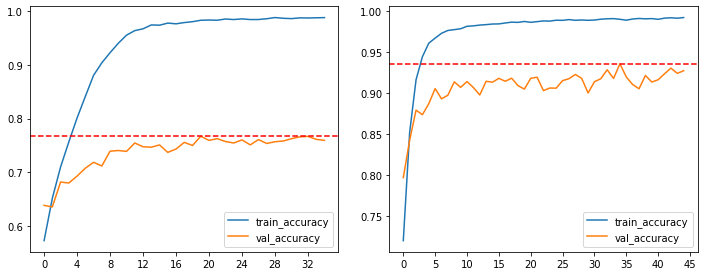

In [12]:
%pylab inline

def show_train_result(train_result=None, ax=None, title=None):
    df = pd.DataFrame({
        'train_loss': train_result['train.score']['loss'],
        'val_loss': train_result['val.score']['loss'],
        'train_accuracy': train_result['train.score']['accuracy'],
        'val_accuracy': train_result['val.score']['accuracy']
    })

    ax = df.loc[:, ['train_accuracy', 'val_accuracy']].plot(ax=ax, title=title, label='best:0.999')
    bs = train_result['best_score']
    ax.axhline(y=bs, ls='--', c='red')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    #     ax.annotate('%0.2f' % bs, (10, bs+0.01))
    print('##############################')
    print('n_epochs: %s' % train_result['n_epochs'])
    print('stopped_epoch: %s' % train_result['stopped_epoch'])
    print('best_epoch: %s' % train_result['best_epoch'])
    print('best_score: %s' % train_result['best_score'])
    print('best_chk: %s' % train_result['best_chk'])


fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_figwidth(10)
fig.set_figheight(4)
plt.tight_layout(h_pad=2, w_pad=2)

show_train_result(train_result=experiment.get_train_result(0), 
                  ax=axes[0])
show_train_result(train_result=experiment.get_train_result(1), 
                  ax=axes[1])


## Loading final fine-tuned model

In [13]:
model = experiment.load_eval_model()
display(model)

# Eval result recoder
eval_recoder = PredResultRecoder(output_attentions=True, output_hidden_states=True)
model.add_pred_listener(eval_recoder)

2021-11-09 20:46:27 [INFO]: Create TAPE model using config: ../config/bert-base/
2021-11-09 20:46:29 [INFO]: Loading the eval model from ../output/exp1/train.1.model_34.chk


BertTCREpitopeModel(
  (bert): ProteinBertModel(
    (embeddings): ProteinBertEmbeddings(
      (word_embeddings): Embedding(30, 768, padding_idx=0)
      (position_embeddings): Embedding(8192, 768)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm()
      (dropout): Dropout(p=0.1)
    )
    (encoder): ProteinBertEncoder(
      (layer): ModuleList(
        (0): ProteinBertLayer(
          (attention): ProteinBertAttention(
            (self): ProteinBertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1)
            )
            (output): ProteinBertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm()
              (dropout): Dropout(p=0.1)
            )
     

## Evaluation results

### Shomuradova <i>et al.</i>

- Performance evaluation for the dataset containing COVID-19 S-protein epitope-specific TCRβs from  Shomuradova <i>et al.</i>

#### Loading eval dataset

In [14]:
from torch.utils.data import DataLoader
from tcrbert.dataset import TCREpitopeSentenceDataset
import numpy as np
from tcrbert.dataset import CN
from tcrbert.bioseq import write_fa

epitope = 'YLQPRTFLL'

sh_ds = TCREpitopeSentenceDataset.from_key('iedb_sars2_shomuradova')
sh_df = sh_ds.df_enc

print(sh_ds.name)
display(sh_df.head(), sh_df.shape)
summary_df(sh_df)

iedb_sars2_shomuradova


,epitope,epitope_gene,epitope_species,species,cdr3b,mhc,source,ref_id,label,sentence
YLQPRTFLL_CASGEGNTGELFF,YLQPRTFLL,Spike glycoprotein,SARS-CoV2,human,CASGEGNTGELFF,HLA-A*02:01,IEDB,IEDB:1037882,1,"[2, 28, 15, 20, 19, 21, 23, 10, 15, 15, 7, 5, ..."
YLQPRTFLL_CASGGTNTGELFF,YLQPRTFLL,Spike glycoprotein,SARS-CoV2,human,CASGGTNTGELFF,HLA-A*02:01,IEDB,IEDB:1037882,1,"[2, 28, 15, 20, 19, 21, 23, 10, 15, 15, 7, 5, ..."
YLQPRTFLL_CASSDLDTGELFF,YLQPRTFLL,Spike glycoprotein,SARS-CoV2,human,CASSDLDTGELFF,HLA-A*02:01,IEDB,IEDB:1037882,1,"[2, 28, 15, 20, 19, 21, 23, 10, 15, 15, 7, 5, ..."
YLQPRTFLL_CASSDIDTGELFF,YLQPRTFLL,Spike glycoprotein,SARS-CoV2,human,CASSDIDTGELFF,HLA-A*02:01,IEDB,IEDB:1037882,1,"[2, 28, 15, 20, 19, 21, 23, 10, 15, 15, 7, 5, ..."
YLQPRTFLL_CASSELAGGNTGELFF,YLQPRTFLL,Spike glycoprotein,SARS-CoV2,human,CASSELAGGNTGELFF,HLA-A*02:01,IEDB,IEDB:1037882,1,"[2, 28, 15, 20, 19, 21, 23, 10, 15, 15, 7, 5, ..."


(670, 10)

,Epitope species,Epitope gene,Epitope,MHC,Samples,Positives
0,SARS-CoV2,Spike glycoprotein precursor,FIAGLIAIV,HLA-A*02:01,2,1
1,SARS-CoV2,Spike glycoprotein precursor,RLQSLQTYV,HLA-A*02:01,56,28
2,SARS-CoV2,Spike glycoprotein,YLQPRTFLL,HLA-A*02:01,612,306


#### Performance evaluation for Shomuradova dataset

2021-11-09 20:58:27 [DEBUG]: Loaded backend module://ipykernel.pylab.backend_inline version unknown.
Populating the interactive namespace from numpy and matplotlib
2021-11-09 20:58:27 [INFO]: ======================
2021-11-09 20:58:27 [INFO]: Begin predict...
2021-11-09 20:58:27 [INFO]: use_cuda, device: False, cpu
2021-11-09 20:58:27 [INFO]: model: BertTCREpitopeModel(
  (bert): ProteinBertModel(
    (embeddings): ProteinBertEmbeddings(
      (word_embeddings): Embedding(30, 768, padding_idx=0)
      (position_embeddings): Embedding(8192, 768)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm()
      (dropout): Dropout(p=0.1)
    )
    (encoder): ProteinBertEncoder(
      (layer): ModuleList(
        (0): ProteinBertLayer(
          (attention): ProteinBertAttention(
            (self): ProteinBertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=Tru

2021-11-09 20:58:27 [INFO]: n_data: 670
2021-11-09 20:58:27 [INFO]: batch_size: 670
2021-11-09 20:58:27 [INFO]: [PredResultRecoder]: on_predict_begin...
2021-11-09 20:58:27 [INFO]: Begin 0/1 prediction batch
2021-11-09 20:58:58 [INFO]: End 0/1 prediction batch
2021-11-09 20:58:58 [INFO]: [PredResultRecoder]: on_predict_end...
2021-11-09 20:59:00 [INFO]: Done to predict...
2021-11-09 20:59:00 [INFO]: ======================
score_map: OrderedDict([('accuracy', 0.9462686567164179), ('f1', 0.9457831325301206), ('roc_auc', 0.9782713299175763)])


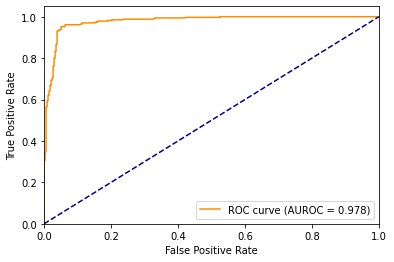

In [15]:
%pylab inline

from sklearn.metrics import roc_curve, auc

metrics = ['accuracy', 'f1', 'roc_auc']
data_loader = DataLoader(sh_ds, batch_size=len(sh_ds), shuffle=False, num_workers=2)
model.predict(data_loader=data_loader, metrics=metrics)

input_labels  = np.array(eval_recoder.result_map['input_labels'])
output_labels = np.array(eval_recoder.result_map['output_labels'])
output_probs  = np.array(eval_recoder.result_map['output_probs'])

fpr, tpr, _ = roc_curve(input_labels, output_probs)
score = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (AUROC = %0.3f)' % score)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")

print('score_map: %s' % eval_recoder.result_map['score_map'])

#### Investigating position-wise attention weights

##### Selecting target CDR3β sequences with most common lengths and predicted as a binder

Populating the interactive namespace from numpy and matplotlib
cum_ratio: 159/300=0.53
target_indices for 13: [  0   1   2   3   5   7   9  11  13  15  18  19  20  21  22  23  24  25
  27  28  31  32  33  35  37  39  43  51  52  57  59  62  65  67  70  71
  74  75  76  78  79  81  82  88  89  90  91  92  93  94  97  99 100 110
 111 113 115 117 118 119 120 123 124 127 129 134 138 139 142 146 147 149
 150 153 154 155 156 158 160 161 162 166 168 169 170 172 173 174 175 176
 177 178 179 180 185 186 188 189 190 192 193 194 197 198 201 202 203 205
 207 211 213 214 217 219 220 223 225 228 231 233 234 237 238 239 240 243
 244 245 247 250 251 252 254 256 261 263 266 267 268 270 271 273 275 277
 279 280 287 289 290 291 292 294 295 296 298 312 533 548 595](159)
cum_ratio: 221/300=0.7366666666666667
target_indices for 16: [  4  16  29  34  40  41  42  44  53  56  60  61  63  83  96 103 105 106
 107 108 112 114 121 132 133 157 164 165 167 171 182 184 191 199 200 204
 208 212 215 216 224 226 236 241

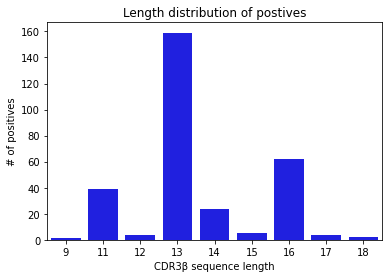

In [207]:
%pylab inline

import matplotlib.pyplot as plt
import matplotlib.image as image

import seaborn as sns
from collections import Counter, OrderedDict

pos_indices = np.where(output_labels == 1)[0]
# print('pos_indices: %s(%s)' % (pos_indices, str(pos_indices.shape)))
pos_cdr3b = sh_df[CN.cdr3b].values[pos_indices]

##########################################
lens, cnts = zip(*sorted(Counter(map(lambda x: len(x), pos_cdr3b)).items()))
lens = np.array(lens)
cnts = np.array(cnts)
ax = sns.barplot(x=lens, y=cnts, color='blue')
ax.set_title('Length distribution of postives')
ax.set_xlabel('CDR3β sequence length')
ax.set_ylabel('# of positives')

# Select target indices by cdr3b sequence lenghts
target_index_map = OrderedDict()
order = np.argsort(cnts)[::-1]
cum_cnt = 0
for cur_len, cur_cnt in zip(lens[order], cnts[order]):
    cum_cnt += cur_cnt
    cum_ratio = cum_cnt/pos_indices.shape[0]
    print('cum_ratio: %s/%s=%s' % (cum_cnt, pos_indices.shape[0], cum_ratio))
    if cum_ratio < 0.9:
        target_indices = np.where((output_labels == 1) & (sh_df[CN.cdr3b].map(lambda x: len(x) == cur_len)))[0]
        print('target_indices for %s: %s(%s)' % (cur_len, target_indices, target_indices.shape[0]))
        target_index_map[cur_len] = target_indices



##### Marginalized position-wise attention weights for target YLQPRTFLL-CDR3b sequences 

- The output attention weights have the dimension $(L, N, H, S, S)$, where $L$ is the number of encoding layers, $N$ is the number of YLQPRTFLL-CDR3β sequence pairs, $H$ is the number of attention heads, and $S$ is the fixed-length of the sequences. The attention weights were marginalized into a one-dimensional vector of length of $S$. A value of the vector at the position $m$, $Am$ is given by the following equation:

<img src='res/eq1.png' width='50%'>

Populating the interactive namespace from numpy and matplotlib
attentions.shape: (12, 610, 12, 40, 40)
Attention weights for 13: [0.01643374 0.01618483 0.01511986 0.02533049 0.01850352 0.01619732
 0.02031346 0.01818909 0.02093069 0.02580083 0.02896048 0.02805906
 0.03447687 0.03893697 0.04397228 0.04865679 0.04153173 0.03341786
 0.03399991 0.03015553 0.0324808  0.02483021]
Attention weights for 16: [0.01615029 0.01575572 0.01507342 0.02620301 0.01740889 0.01676265
 0.02014595 0.01809091 0.01943124 0.02402712 0.02206711 0.02278116
 0.02781942 0.04411919 0.03942972 0.04424402 0.0399127  0.04292218
 0.03710573 0.03339493 0.03230027 0.0273747  0.0244459  0.02751078
 0.02266816]
Attention weights for 11: [0.01634049 0.01784765 0.01617169 0.02543226 0.0187478  0.01719312
 0.02091213 0.01858995 0.02114859 0.02412    0.02802869 0.02511326
 0.03023196 0.04010335 0.0490456  0.04375431 0.04716745 0.04065299
 0.03837138 0.02809359]


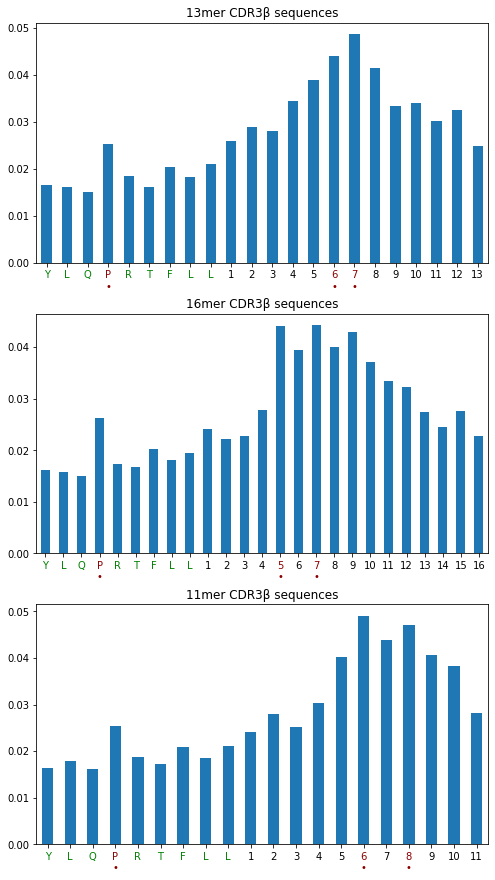

In [208]:
%pylab inline

# n_layers = model.config.num_hidden_layers
# n_data = len(eval_ds)
# n_heads = model.config.num_attention_heads
# max_len = eval_ds.max_len

epitope_len = len(epitope)

attentions = eval_recoder.result_map['attentions']
# attentions.shape: (n_layers, n_data, n_heads, max_len, max_len)
print('attentions.shape: %s' % str(attentions.shape))

# target_attn_map = OrderedDict()

fig, axes = plt.subplots(nrows=3, ncols=1)
fig.set_figwidth(7)
fig.set_figheight(12)
plt.tight_layout(h_pad=3, w_pad=3)

for i, (cur_len, cur_indices) in enumerate(target_index_map.items()):
    attns = attentions[:, cur_indices]
    sent_len = epitope_len + cur_len
    
    # Position-wise marginal attentions by mean
    attns = np.mean(attns, axis=(0, 1, 2, 3))[1:sent_len+1]
    print('Attention weights for %s: %s' % (cur_len, attns))
    
    ax = pd.Series(attns).plot(kind='bar', ax=axes[i], rot=0)
    ax.set_title('%smer CDR3β sequences' % cur_len)

    ticks = list(epitope) + list(range(1, cur_len + 1))
    mark_ratio = 0.1
    mark_pos = []

    for rank, pos in enumerate(np.argsort(attns[:epitope_len])[::-1]):
        if rank < (epitope_len*mark_ratio):
            ticks[pos] = '%s\n•' % (ticks[pos])
            mark_pos.append(pos)

    for rank, pos in enumerate(np.argsort(attns[epitope_len:])[::-1]):
        if rank < (tcr_len*mark_ratio):
            ticks[epitope_len+pos] = '%s\n•' % (ticks[epitope_len+pos])
            mark_pos.append(epitope_len+pos)

    ax.set_xticklabels(ticks) 
    for i, tick in enumerate(ax.get_xticklabels()):
        if i < epitope_len:
            tick.set_color('green')
        else:
            tick.set_color('black')
        if i in mark_pos:
            tick.set_color('darkred')

### ImmuneCODE dataset

-  The dataset contained 718 COVID-19 S-protein<sub>269-277</sub>-specific TCRs from the ImmuneRACE study launched by Adaptive Biotechnologies and Microsoft (https://immunerace.adaptivebiotech.com, June 10, 2020 dataset, from hereafter referred to as ImmuneCODE dataset

#### Loading eval dataset

In [219]:
im_ds = TCREpitopeSentenceDataset.from_key('immunecode')

display(im_ds.name, len(im_ds))

# Remove duplicated CDR3beta seqs with Shomuradova
im_ds.df_enc = im_ds.df_enc[
        im_ds.df_enc[CN.cdr3b].map(lambda seq: seq not in sh_df[CN.cdr3b].values)
]
print('After removing duplicates, len(im_ds): %s' % len(im_ds))
display(summary_df(im_df), im_df.shape)

'immunecode'

742

After removing duplicates, len(im_ds): 718


,Epitope species,Epitope gene,Epitope,MHC,Samples,Positives
0,SARS-CoV-2,Spike,YLQPRTFLL,-,718,328


(718, 9)

#### Performance evaluation for the ImmuneCODE dataset

Populating the interactive namespace from numpy and matplotlib
2021-11-05 22:44:36 [INFO]: ======================
2021-11-05 22:44:36 [INFO]: Begin predict...
2021-11-05 22:44:36 [INFO]: use_cuda, device: False, cpu
2021-11-05 22:44:36 [INFO]: model: BertTCREpitopeModel(
  (bert): ProteinBertModel(
    (embeddings): ProteinBertEmbeddings(
      (word_embeddings): Embedding(30, 768, padding_idx=0)
      (position_embeddings): Embedding(8192, 768)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm()
      (dropout): Dropout(p=0.1)
    )
    (encoder): ProteinBertEncoder(
      (layer): ModuleList(
        (0): ProteinBertLayer(
          (attention): ProteinBertAttention(
            (self): ProteinBertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout

2021-11-05 22:44:36 [INFO]: n_data: 718
2021-11-05 22:44:36 [INFO]: batch_size: 718
2021-11-05 22:44:36 [INFO]: [PredResultRecoder]: on_predict_begin...
2021-11-05 22:44:36 [INFO]: Begin 0/1 prediction batch
2021-11-05 22:44:46 [INFO]: End 0/1 prediction batch
2021-11-05 22:44:46 [INFO]: [PredResultRecoder]: on_predict_end...
2021-11-05 22:44:47 [INFO]: Done to predict...
2021-11-05 22:44:47 [INFO]: ======================
score_map: OrderedDict([('accuracy', 0.9484679665738162), ('f1', 0.9443609022556392), ('roc_auc', 0.9827900250156348)])


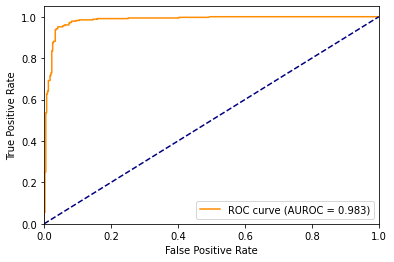

In [210]:
%pylab inline

from sklearn.metrics import roc_curve, auc

data_loader = DataLoader(im_ds, batch_size=len(im_ds), shuffle=False, num_workers=2)
model.predict(data_loader=data_loader, metrics=metrics)

input_labels  = np.array(eval_recoder.result_map['input_labels'])
output_labels = np.array(eval_recoder.result_map['output_labels'])
output_probs  = np.array(eval_recoder.result_map['output_probs'])

fpr, tpr, _ = roc_curve(input_labels, output_probs)
score = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (AUROC = %0.3f)' % score)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")

print('score_map: %s' % eval_recoder.result_map['score_map'])

#### Investigating position-wise attention weights

##### Selecting target CDR3β sequences with most common lengths and predicted as a binder

Populating the interactive namespace from numpy and matplotlib
cum_ratio: 160/337=0.47477744807121663
target_indices for 13: [  0   5   9  11  16  17  18  19  21  26  27  28  30  32  33  36  40  41
  42  43  44  45  46  47  48  55  56  60  63  65  68  69  71  74  75  77
  84  85  86  87  90  93  94 100 105 106 107 109 110 111 113 114 115 118
 126 127 129 131 133 135 138 140 145 147 148 151 154 156 157 163 166 167
 168 170 172 174 175 176 177 181 183 184 188 190 191 192 194 196 199 200
 201 202 203 204 207 208 209 210 211 216 219 220 222 223 224 226 230 231
 233 234 235 239 240 247 254 255 258 259 260 261 263 264 265 266 269 280
 281 282 283 286 289 290 292 293 295 297 298 299 304 306 308 310 312 314
 317 318 319 320 321 323 324 325 326 327 357 406 408 522 551 648](160)
cum_ratio: 220/337=0.6528189910979229
target_indices for 14: [  7  22  29  37  39  49  52  53  54  78  82  83  88 101 102 104 117 120
 121 128 134 136 142 144 150 152 159 160 161 164 178 179 185 186 193 205
 212 213 229 

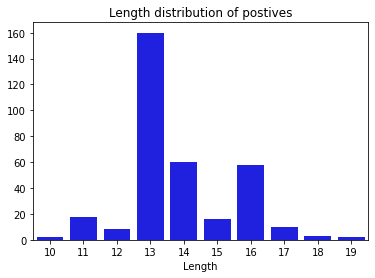

In [212]:
%pylab inline

import matplotlib.pyplot as plt
import matplotlib.image as image

import seaborn as sns
from collections import Counter, OrderedDict

pos_indices = np.where(output_labels == 1)[0]
# print('pos_indices: %s(%s)' % (pos_indices, str(pos_indices.shape)))
pos_cdr3b = im_df[CN.cdr3b].values[pos_indices]

##########################################
lens, cnts = zip(*sorted(Counter(map(lambda x: len(x), pos_cdr3b)).items()))
lens = np.array(lens)
cnts = np.array(cnts)
ax = sns.barplot(x=lens, y=cnts, color='blue')
ax.set_title('Length distribution of postives')
ax.set_xlabel('Length')

# Select target indices by cdr3b sequence lenghts
target_index_map = OrderedDict()
order = np.argsort(cnts)[::-1]
cum_cnt = 0
for cur_len, cur_cnt in zip(lens[order], cnts[order]):
    cum_cnt += cur_cnt
    cum_ratio = cum_cnt/pos_indices.shape[0]
    print('cum_ratio: %s/%s=%s' % (cum_cnt, pos_indices.shape[0], cum_ratio))
    if cum_ratio < 0.85:
        target_indices = np.where((output_labels == 1) & (im_df[CN.cdr3b].map(lambda x: len(x) == cur_len)))[0]
        print('target_indices for %s: %s(%s)' % (cur_len, target_indices, target_indices.shape[0]))
        target_index_map[cur_len] = target_indices


##### Marginalized position-wise attention weights for target YLQPRTFLL-CDR3b sequences 

Populating the interactive namespace from numpy and matplotlib
attentions.shape: (12, 718, 12, 40, 40)
Current attns for 13: [0.01630678 0.01613801 0.01512098 0.02522577 0.01851558 0.01629829
 0.02041456 0.01825941 0.02079002 0.02608216 0.02811108 0.02789923
 0.03508032 0.03850946 0.04396208 0.04873751 0.04107358 0.0334924
 0.0340323  0.03055419 0.03295862 0.02484329]
Current attns for 14: [0.01691636 0.01579219 0.01506595 0.0244922  0.01811742 0.01655911
 0.02009635 0.01797518 0.02025169 0.0232316  0.02521668 0.02977495
 0.03149963 0.03937949 0.04025109 0.0436696  0.04712518 0.04287682
 0.03323653 0.03407052 0.02859696 0.02776003 0.02307034]
Current attns for 16: [0.0161272  0.01577951 0.01493868 0.02566106 0.01749486 0.01673275
 0.02000752 0.01790751 0.01934386 0.02318233 0.02239559 0.02363846
 0.02733669 0.04140983 0.03949562 0.0435888  0.03881311 0.04322024
 0.03894608 0.03375197 0.03373761 0.02654229 0.02398934 0.02749936
 0.02230487]


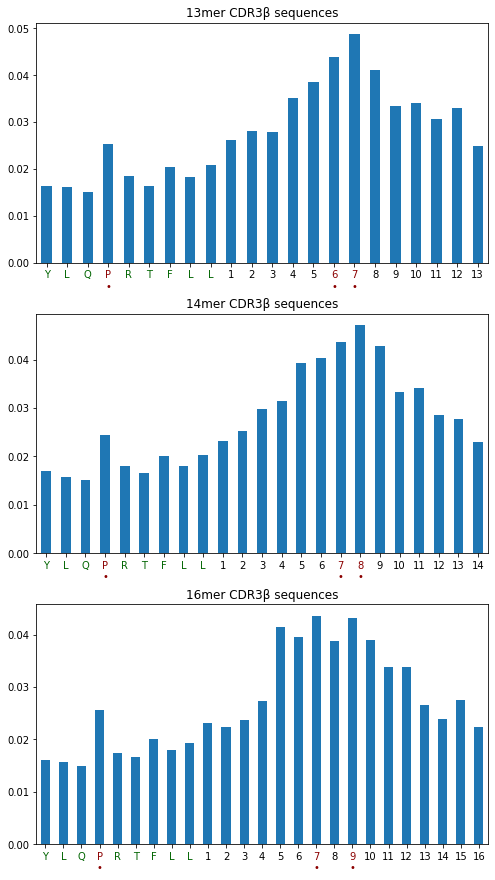

In [214]:
%pylab inline

# n_layers = model.config.num_hidden_layers
# n_data = len(eval_ds)
# n_heads = model.config.num_attention_heads
# max_len = eval_ds.max_len

epitope_len = len(epitope)

attentions = eval_recoder.result_map['attentions']
# attentions.shape: (n_layers, n_data, n_heads, max_len, max_len)
print('attentions.shape: %s' % str(attentions.shape))

# target_attn_map = OrderedDict()

fig, axes = plt.subplots(nrows=3, ncols=1)
fig.set_figwidth(7)
fig.set_figheight(12)
plt.tight_layout(h_pad=3, w_pad=3)

for i, (cur_len, cur_indices) in enumerate(target_index_map.items()):
    attns = attentions[:, cur_indices]
    sent_len = epitope_len + cur_len
    
    # Position-wise marginal attentions by mean
    attns = np.mean(attns, axis=(0, 1, 2, 3))[1:sent_len+1]
    print('Current attns for %s: %s' % (cur_len, attns))
    
    ax = pd.Series(attns).plot(kind='bar', ax=axes[i], rot=0)
    ax.set_title('%smer CDR3β sequences' % cur_len)

    ticks = list(epitope) + list(range(1, cur_len + 1))
    mark_ratio = 0.1
    mark_pos = []

    for rank, pos in enumerate(np.argsort(attns[:epitope_len])[::-1]):
        if rank < (epitope_len*mark_ratio):
            ticks[pos] = '%s\n•' % (ticks[pos])
            mark_pos.append(pos)

    for rank, pos in enumerate(np.argsort(attns[epitope_len:])[::-1]):
        if rank < (tcr_len*mark_ratio):
            ticks[epitope_len+pos] = '%s\n•' % (ticks[epitope_len+pos])
            mark_pos.append(epitope_len+pos)

    ax.set_xticklabels(ticks) 
    for i, tick in enumerate(ax.get_xticklabels()):
        if i < epitope_len:
            tick.set_color('darkgreen')
        else:
            tick.set_color('black')
        if i in mark_pos:
            tick.set_color('darkred')
    
